<h2><center>Applied Machine Learning - Assignment 10</center></h2>
<h4><center>Lorenzo Cirac Monteagduo</center></h4>

In [1]:
import scipy.sparse as sparse
import matplotlib.pyplot as plt
import numpy as np
import time

from sklearn.datasets import load_svmlight_file, dump_svmlight_file
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

<h3>Datasets</h3>
<ul>
    <li>IRIS dataset D1</li>
    <li>rcv1v2 (topics; subsets) D2</li>
    <li>20 Newsgroups dataset D3</li>
</ul>

<h3>Question 1 - Implement K-Means Clustering Algorithm</h3>
<p>Implement the K-Means (cluster-kmeans) algorithm using dataset D1 or D2. Your implementation should handle sparse data (Note: D2 is a sparse dataset; see Annex below for more details). Finally, choose a criterion for selecting an optimal value of k (number of clusters)</p>

<h4>Solution</h4>

<h4>cluster-kmeans implementation</h4>

<p>Given the difficulty of the task, I implemented a Python class performing cluster-kmeans. Since my implementation is based on the given pseudocode, I will emphasize in my code the key parts that are really important:</p>

<h5>1) _sparse_squared_distances(self, X, Y)</h5>
<p>The following part is the most important of the implementation, as it does an efficient distance calculation. It handles sparse data points (X) and dense centroids (Y) for sparse matrix-specific operations to minimize memory use and computation time: </p>
<p>Euclidean distance matrix calculation:</p>
$$||x - y|| = \sqrt{((x - y)^T(x - y))}$$
<p>When we expand $(x - y)^T(x - y)$, we get:</p>
$$||x - y|| = \sqrt{((x - y)^T(x - y))} = x^Tx - 2x^Ty + y^Ty$$

<h5>2) plot_results(self, X)</h5>
<p>For this function, we will plot the clustering results for IRIS dataset, D1. We will reduce the data and centroids to two principal components using PCA from scikit-learn for plotting</p>

In [2]:
class Cluster_KMeans:
    
    def __init__(self, k, epsilon = 1e-4):
        self.k = k  
        self.epsilon = epsilon
        
        self.P = None
        self.fit_time = None
    
    def fit(self, X):
        start_time = time.time()

        self.centroids = self._init_centroids(X)
        
        while True:
            old_centroids = self.centroids.copy()
            
            distances = self._sparse_squared_distances(X, self.centroids.toarray())
            self.P = distances.argmin(axis = 1)
            
            new_centroids = []
            
            for k in range(self.k):
                mask = self.P == k
                
                if mask.any():
                    cluster_mean = X[mask].mean(axis = 0)
                    new_centroids.append(sparse.csr_matrix(cluster_mean))
                else:
                    # edge case empty clusters
                    new_idx = np.random.randint(0, X.shape[0])
                    new_centroids.append(X[new_idx])
                
            self.centroids = sparse.vstack(new_centroids)
            
            centroid_shifts = self._sparse_squared_distances(old_centroids, self.centroids.toarray()).diagonal()
            
            if (centroid_shifts.sum() / self.k) < self.epsilon:
                break

        self.fit_time = time.time() - start_time
        return self

    def _sparse_squared_distances(self, X, Y):
        X_squared = X.multiply(X).sum(axis = 1).A1
        Y_squared = np.square(Y).sum(axis = 1)
        cross_terms = X.dot(Y.T)
    
        distances = X_squared[:, np.newaxis] - 2 * cross_terms + Y_squared 
        distances[distances < 0] = 0
    
        return np.sqrt(distances)
    
    def _init_centroids(self, X):
        N = X.shape[0]
        
        i_0 = np.random.randint(0, N)
        centroids = [X[i_0]]
        
        for k in range(1, self.k):
            current_centroids = np.vstack([c.toarray() for c in centroids])
            distances = self._sparse_squared_distances(X, current_centroids)
            
            sum_distances = distances.sum(axis = 1)
            next_centroid_idx = np.argmax(sum_distances)
            centroids.append(X[next_centroid_idx])
        
        return sparse.vstack(centroids)

    def plot_results(self, X):
        plt.figure(figsize = (10, 6))
        
        X_dense = X.toarray() if sparse.issparse(X) else np.array(X)
        centroids_dense = self.centroids.toarray() if sparse.issparse(self.centroids) else self.centroids
        
        X_scaled = StandardScaler().fit_transform(X_dense)
        centroids_scaled = StandardScaler().fit_transform(centroids_dense)
        
        pca = PCA(n_components = 2)
        X_pca = pca.fit_transform(X_scaled)
        centroids_pca = pca.transform(centroids_scaled)
        
        colors = plt.cm.rainbow(np.linspace(0, 1, self.k))
        
        for k in range(self.k):
            cluster_mask = (self.P == k)

            # cluster plot
            plt.scatter(X_pca[cluster_mask, 0], X_pca[cluster_mask, 1], color = [colors[k]], label = f'Cluster {k}')

            # centroid plot
            plt.scatter(centroids_pca[k, 0], centroids_pca[k, 1], color = 'black', marker = 'x', s  = 100)

        plt.title('Clustering Results')
        plt.legend()
        plt.show()

<h4>D1 - dense data</h4>
<p>We will use load_svmlight_file from scikit-learn to load our D1 data (libsvm format)</p>

In [3]:
D1 = "res/iris.scale.txt"
X_D1, y_D1 = load_svmlight_file(D1)

In [4]:
kmeans_D1 = Cluster_KMeans(k = 3)
results_D1 = kmeans_D1.fit(X_D1)

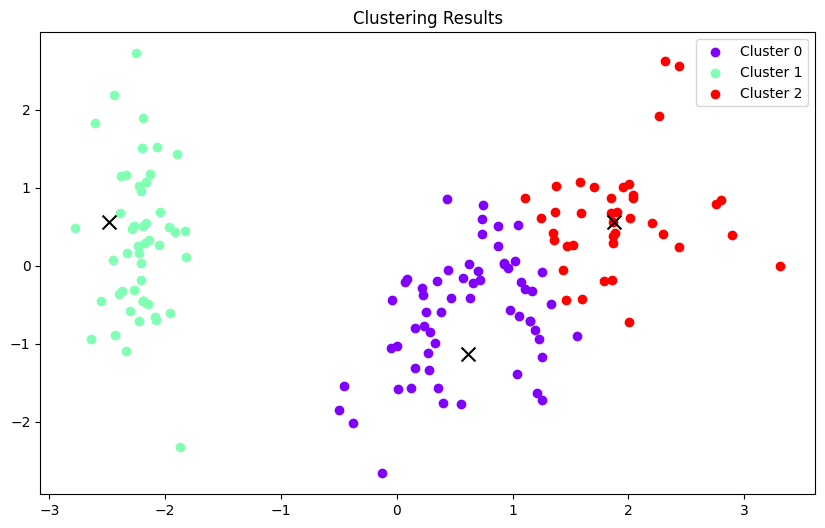

In [5]:
kmeans_D1.plot_results(X_D1)

<h4>Optimal k</h4>

In [6]:
from sklearn.metrics import silhouette_score

<p>To measure the clustering quality, we will use the silhouette score metric from scikit-learn. The silhouette score measures how similar each point is to its own cluster compared to other clusters. The range of silhouette coefficient ranges from -1 to 1, where a value close to 1 indicates that the points are well-clustered. A score close to 0 implies that the points lie at or near the decision boundary between clusters, and a negative score suggests that there was possibly an incorrect assignment to a cluster. Later, we will be calculating the silhouette score for different values of k, to identify the value of k that maximizes the score, which corresponds to the most appropriate number of clusters for the dataset.  (https://en.wikipedia.org/wiki/Silhouette_(clustering))</p>

<p>The silhouette score for a point i is calculated using the following formula:</p>
$$s(i) = \frac{b(i) - a(i)}{max(a(i), b(i))}$$

<ull>
    <li>$a(i)$ is the average distance between point i and all other points in the same cluster</li>
    <li>$b(i)$ is the minimum average distance from point i to all points in any other cluster</li>   
    <li>The overall silhouette score for the clustering is the average of the individual silhouette scores for all points</li>
</ul>
<br>
<p>To determine the optimal number of clusters (k), we will compare the silhouette scores for different values of k and select the one that yields the highest score.</p>

In [7]:
def find_optimal_k(X, min_k = 2, max_k = 10, verbose = True):
        
    silhouette_scores = []
    
    for k in range(min_k, max_k + 1):
    
        kmeans = Cluster_KMeans(k = k)
        results = kmeans.fit(X)
        P = results.P
        
        score = silhouette_score(X, P)
        silhouette_scores.append(score)
        
        if verbose:
            print(f'K = {k:<2} | Silhouette Score: {score:.4f}')
    
    plt.figure(figsize = (10, 6))
    plt.plot(range(min_k, max_k + 1), silhouette_scores, marker = 'o')
    plt.title('Silhouette Scores for Different K')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Silhouette Score')
    plt.show()
    
    optimal_k = np.argmax(silhouette_scores) + min_k
    
    return optimal_k

K = 2  | Silhouette Score: 0.6295
K = 3  | Silhouette Score: 0.5043
K = 4  | Silhouette Score: 0.3973
K = 5  | Silhouette Score: 0.3257
K = 6  | Silhouette Score: 0.3112
K = 7  | Silhouette Score: 0.3402
K = 8  | Silhouette Score: 0.2878
K = 9  | Silhouette Score: 0.3077
K = 10 | Silhouette Score: 0.3108


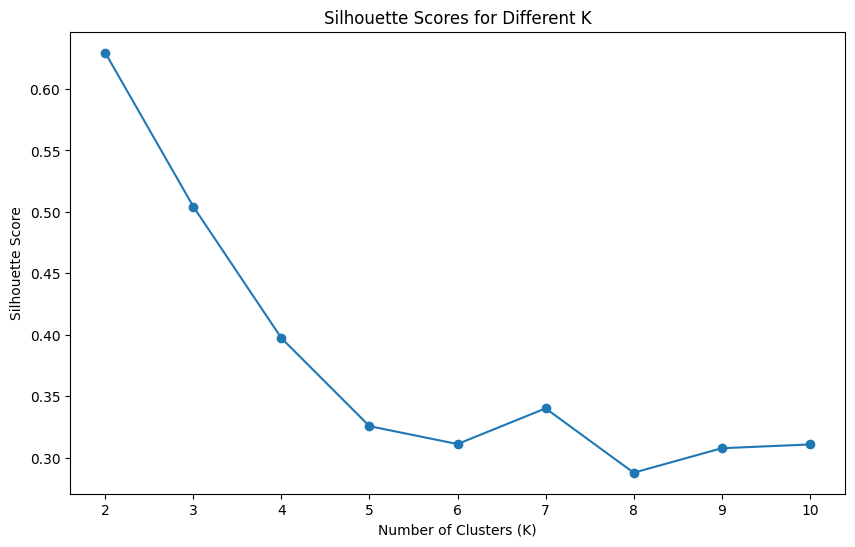

In [8]:
optimal_k_D1 = find_optimal_k(X_D1)

<p>As observed in the previous plot, it appears quite evident that the optimal number of clusters is 2:</p>

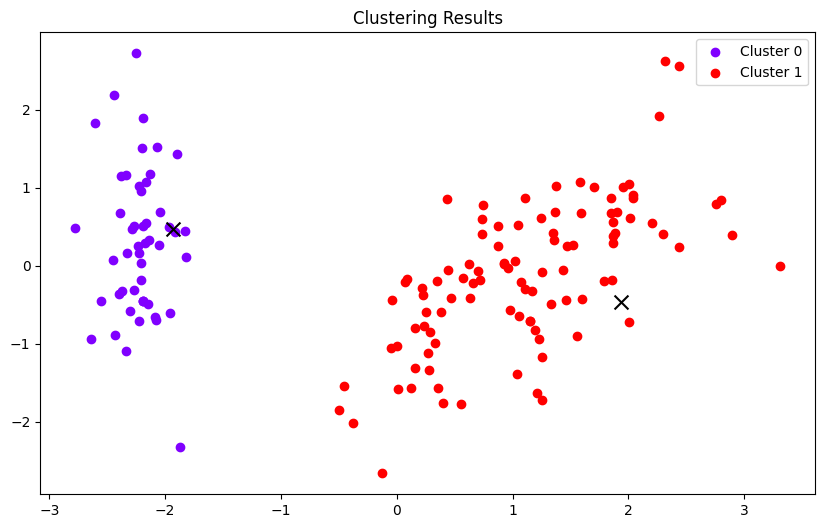

In [9]:
kmeans_D1 = Cluster_KMeans(k = 2)
results_D1 = kmeans_D1.fit(X_D1)
kmeans_D1.plot_results(X_D1)

<h4>D2 - sparse data</h4>
<p>Since the D2 data is in libsvm format, but the labels are not numeric, we need to encode the labels for our model. So, I will create a new file where the labels are numerically encoded:</p>

In [11]:
from sklearn.preprocessing import LabelEncoder

input_file = 'res/Index_EN-EN'
output_file = 'res/Index_EN-EN.numeric'

labels = []
features = []

with open(input_file, 'r') as f:
    for line in f:
        parts = line.split(maxsplit = 1)
        labels.append(parts[0])
        features.append(parts[1])

label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(labels)

with open(output_file, 'w') as f:
    for label, feature in zip(numeric_labels, features):
        f.write(f"{label} {feature}")

<p>Now, we can load the encoded data using load_svmlight_file just like we did before:</p>

In [12]:
X_D2, y_D2 = load_svmlight_file('res/Index_EN-EN.numeric')

In [13]:
kmeans_D2 = Cluster_KMeans(k = 6)
results_D2 = kmeans_D2.fit(X_D2)

print(f'Fit time: {results_D2.fit_time:.4f} seconds')

Fit time: 0.1494 seconds


<p>As we can see, the algorithm performs very quickly. Now, let's test it with a larger dataset to further evaluate its efficiency and scalability.</p>

In [14]:
sparse_matrix = sparse.random(100000, 1000, density = 0.1, format = 'csr')
kmeans_sparse_matrix = Cluster_KMeans(k = 10)
results_sparse_matrix = kmeans_sparse_matrix.fit(sparse_matrix)

print(f'Fit time: {results_sparse_matrix.fit_time:.4f} seconds')

Fit time: 5.2565 seconds


<h3>Quesition 2 - Cluster News Articles</h3>
<p>The dataset D3 (20Newsgroups) can be downloaded as 20news-bydate.tar.gz. Each news
article is stored in its group folder (e.g., articles corresponding to “alt.atheism” are in the
alt.atheism folder). Pre-process the data and extract features for each document. Store the
data in a libsvm file format. Use the provided train and test splits.</p>
<ol>
    <li>Cluster the 20Newsgroups dataset using your implementation of the K-Means algorithm.
Use the test data to measure the clustering quality.</li>
    <li>Use a K-Means implementation from a software library of your choice. Compare the results
of your implementation with the library’s implementation:
    <ul>
        <li>What is the optimal value of k in each case?</li>
        <li>Which implementation takes longer (time your program)?</li>
    </ul>
    </li>
</ol>
<p>Hint: Use Python’s time or timeit libraries for timing your code. Note that you are not
allowed to use sklearn.datasets.fetch 20newsgroups for Exercise 1 or 2.</p>

<h4>Solution</h4>

<h4>Data Preprocessing</h4>

<p>To extract the data from the 20News-bydate folder, we are going to create two arrays: one for the text content of each file and another for its corresponding labels. This is done by iterating over all subfolders and their respective files. Each subfolder represents a category and hence gets a unique label associated with it. The function provides an option to extract data from either the training set, the test set, or both, depending on the specified subset parameter.</p>

In [16]:
import os

def load_20newsgroups(subset = 'all'):
    
    def process_directory(directory):
        documents = []
        labels = []
        
        categories = sorted([d for d in os.listdir(directory) 
                           if os.path.isdir(os.path.join(directory, d))])
        
        category_to_label = {cat: idx for idx, cat in enumerate(categories)}
        
        for category in categories:
            category_path = os.path.join(directory, category)
            
            for filename in os.listdir(category_path):
                file_path = os.path.join(category_path, filename)
                
                try:
                    with open(file_path, 'r', encoding = 'utf-8', errors = 'ignore') as f:
                        content = f.read()
                        
                    documents.append(content)
                    labels.append(category_to_label[category])
                except Exception as e:
                    continue
                    
        return documents, labels

    all_documents = []
    all_labels = []
    
    if subset in ['train', 'all']:
        train_docs, train_labels = process_directory('res/20News-bydate/20News-bydate-train')
        all_documents.extend(train_docs)
        all_labels.extend(train_labels)
        
    if subset in ['test', 'all']:
        test_docs, test_labels = process_directory('res/20News-bydate/20News-bydate-test')
        all_documents.extend(test_docs)
        all_labels.extend(test_labels)
    
    return all_documents, np.array(all_labels)

In [17]:
X_D3_all, y_D3_all = load_20newsgroups(subset = 'all')

X_D3_train, y_D3_train = load_20newsgroups(subset = 'train')
X_D3_test, y_D3_test = load_20newsgroups(subset = 'test')

<p>To transform the text data into numeric features, we will use the TfidfVectorizer from scikit-learn, as in the previous exercise. This allows us to convert text into numerical representations while also providing the option to remove stopwords, such as commonly used words like "the" and "a," which may not contribute significantly to the model's performance. Also, we will set max_df = 0.9 to ignore terms that appear in more than 90% of the documents.</p>

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words = 'english', max_df = 0.9, max_features = 5000)

X_D3_train = vectorizer.fit_transform(X_D3_train)
X_D3_test = vectorizer.transform(X_D3_test)

<h4>Store Data as libsvm format</h4>

In [19]:
dump_svmlight_file(X_D3_train, y_D3_train, 'D3_train') 
dump_svmlight_file(X_D3_test, y_D3_test, 'D3_test')

<h4>Optimal k</h4>

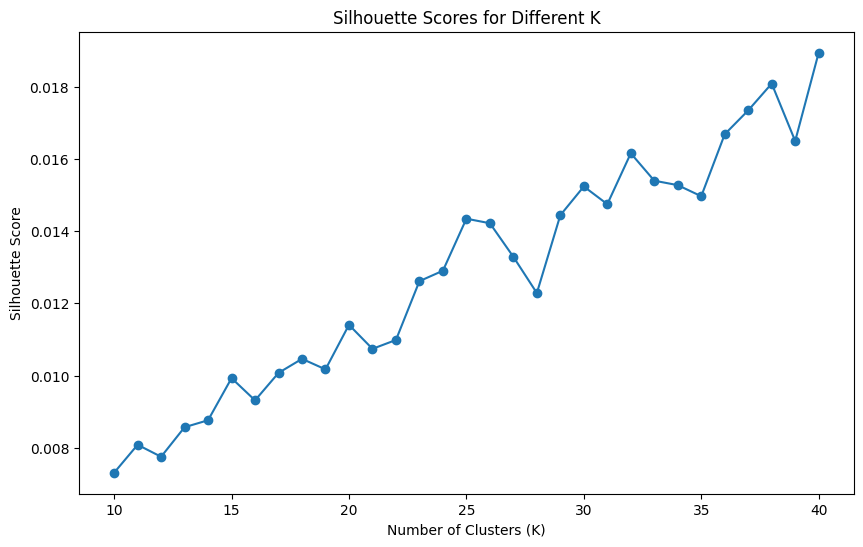

In [20]:
optimal_implementation_k = find_optimal_k(X_D3_test, min_k = 10, max_k = 40, verbose = False)

In [21]:
from sklearn.cluster import KMeans

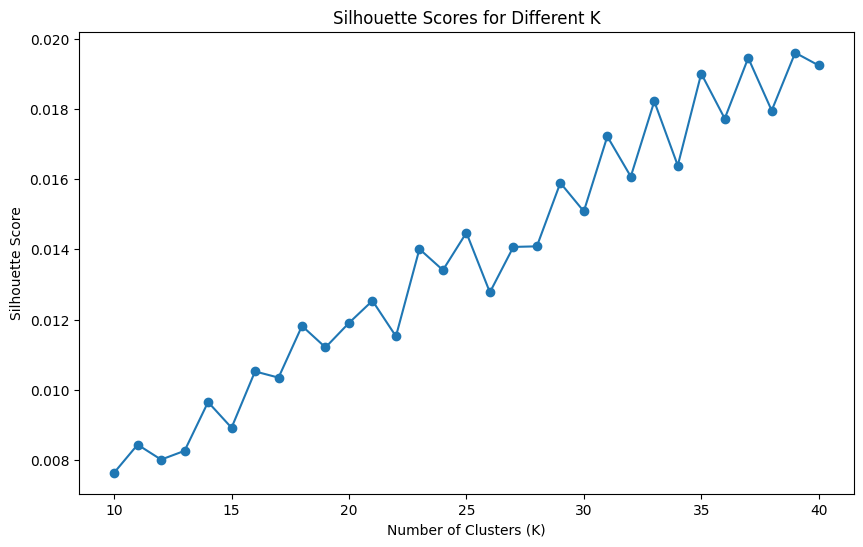

In [22]:
silhouette_scores = []
    
for k in range(10, 41):
        
    kmeans_sklearn = KMeans(n_clusters = k)
    results = kmeans_sklearn.fit(X_D3_test)
    labels = results.labels_
        
    silhouette_sklearn = silhouette_score(X_D3_test, labels)
    silhouette_scores.append(silhouette_sklearn)
        
plt.figure(figsize = (10, 6))
plt.plot(range(10, 41), silhouette_scores, marker = 'o')
plt.title('Silhouette Scores for Different K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.show()

optimal_sklearn_k = np.argmax(silhouette_scores) + 10

<p>
The Silhouette Score tends to increase as the number of clusters increases. This makes sense since smaller clusters have data points closer together, hence reducing the intra-cluster distance. Similarly, when k approaches the number of data points, the Silhouette Score becomes artificially high, as every point forms its own cluster. This underlines that the choice of k should be made with care. Too much clustering leads to overfitting and might result in less interpretability and reduced usefulness for real-world applications.

However, with increasing dimensionality of the data, it becomes difficult to achieve such high values because of the curse of dimensionality, as the distances become more similar. According to Wikipedia, "The silhouette score is specialized for measuring cluster quality when the clusters are convex-shaped, and may not perform well if the data clusters have irregular shapes or are of varying sizes" (https://en.wikipedia.org/wiki/Silhouette_(clustering))</p>

<h4>Fit time comparisson</h4>

In [23]:
kmeans_implementation = Cluster_KMeans(k = optimal_implementation_k)
results_implementation = kmeans_implementation.fit(X_D3_test)

silhouette_implementation = silhouette_score(X_D3_test, results_implementation.P)
print(f'Silhouette Score: {silhouette_implementation:.4f} | Fit time: {results_implementation.fit_time:.4f} seconds')

Silhouette Score: 0.0189 | Fit time: 0.5645 seconds


In [24]:
kmeans_sklearn = KMeans(n_clusters = optimal_sklearn_k)

start_time = time.time()
results_sklearn = kmeans_sklearn.fit(X_D3_test)
fit_time = time.time() - start_time

silhouette_sklearn = silhouette_score(X_D3_test, results_sklearn.labels_)
print(f'Silhouette Score: {silhouette_sklearn:.4f} | Fit time: {fit_time:.4f} seconds')

Silhouette Score: 0.0176 | Fit time: 0.2275 seconds


<p>The Scikit-learn implementation is better in terms of clustering quality and efficiency compared to the custom K-Means implementation. It produces slightly more accurate clusters while requiring less time to complete the fitting process</p>